Before the implementation, let's understand how the data is generated. 
The `generate_data` method takes 2 parameters as input - number of samples and some seed to fix an output of the PRNG and make an experiment repeatable.
In this method you can easily change the means of 2 clusters to test classifiers on different data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def generate_data(n_samples = 100, seed = 123):
    np.random.seed(seed)     # to make the experiment repeatable, let's will fix the seed
    mean1 = np.array([2,2])  
    cov1 = np.array([[1,0],[0,1]])
    class_1 = np.random.multivariate_normal(mean1, cov1, n_samples)

    mean2 = np.array([-3,-3])
    cov2 = np.array([[1,0],[0,1]])
    class_2 = np.random.multivariate_normal(mean2, cov2, n_samples)
    
    y1 = np.ones((n_samples, 1))  
    y2 = y1*(-1)
    data_with_labels_class_1 = np.hstack((class_1, y1)) # hstack - horizontal union, add a third column equal to 1 to each coordinate
    data_with_labels_class_2 = np.hstack((class_2, y2))

    data = np.vstack((data_with_labels_class_1, data_with_labels_class_2)) # vstack - vertical union, combines points from two classes into one array
    np.random.shuffle(data)
    return data



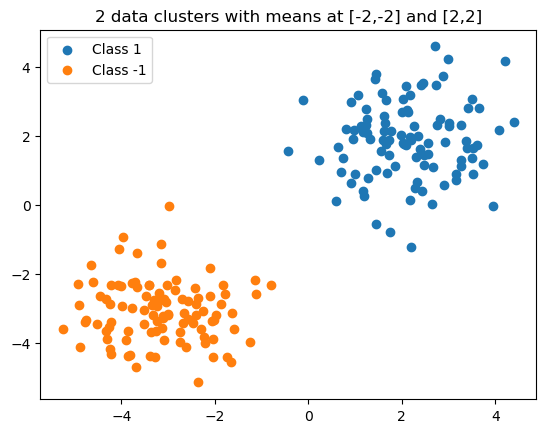

In [3]:
data = generate_data()

X = data[:, :-1] # выбери все строки, в каждой строке выбери все кроме последнего 
y = data[:, -1]

plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1')
plt.scatter(X[y == -1, 0], X[y == -1, 1], label='Class -1')
plt.legend()
plt.title('2 data clusters with means at [-2,-2] and [2,2]')
plt.show()

## Rosenblatt's perceptrone

Loss functions, that we want to minimize has the form $$L(w,b) = \frac{1}{N} \sum_{i=1}^N \texttt{max}  (0, -y_i*(\langle w, x_i \rangle+b))$$ for $N$ data points where $x_i$ data points and $y_i$ corresponindg labels.

In [4]:
def peceptrone_loss(data, w, b):
    X = data[:, :-1]
    y = data[:, -1]
    loss = np.maximum(0, - y * (np.dot(X, w) + b)).mean()
    return loss

Here we use minibatches. For a given number of epochs, repeat:
at the very beginning choose random parameters w and b
1. mix the data
2. divide the obtained data into batches, in our case 10 pieces each
3. for each sample from the batches, calculate the gradient, i.e. how each point affects the loss function (whether the model correctly determines it).
4. sum up the gradients for each point from the batches and then find the average.
5. substract the obtained value from the previous values of w and b - i.e. go in the direction of minimising the loss function

In [5]:
def stochastic_subgradient(data, learning_rate=0.1, batch_size=10, num_of_epochs=50):
    data = generate_data()
    X = data[:, :-1]
    y = data[:, -1]
    num_samples, num_features = X.shape

    w = np.random.randn(num_features)  # Маленькие случайные числа
    b = np.random.randn()
    
    history = [] # For animation frames

    for epoch in range(num_of_epochs):
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            #X_batch = X[i:i+batch_size]
            #y_batch = y[i:i+batch_size]
            batch = data[i:i+batch_size]
            grad_w = np.zeros_like(w)
            grad_b = 0.0
            for sample in batch:
                x_i = sample[:-1]
                y_i = sample[-1]
                if y_i * (np.dot(w, x_i) + b) < 0:
                    grad_w += (-y_i * x_i)
                    grad_b += (-y_i)
                else:
                    grad_w += 0
                    grad_b += 0
            grad_w /= batch_size
            grad_b /= batch_size

            w -= learning_rate*grad_w
            b -= learning_rate*grad_b
            #print(f"w = {w}, b = {b}")
            loss = peceptrone_loss(data, w, b)  # Calculate loss after update
            history.append((w.copy(), b, loss)) # Append for animation
    return w, b, history





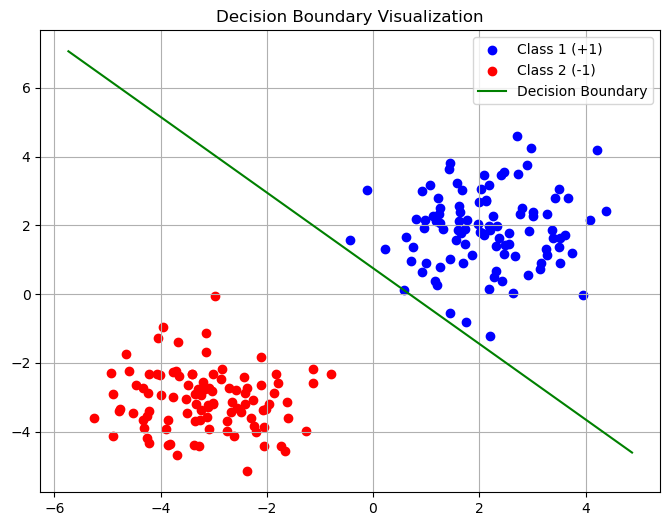

In [6]:
def visualize_decision_boundary(data, w, b):
    plt.figure(figsize=(8, 6))
    class_1 = data[data[:, -1] == 1]
    class_2 = data[data[:, -1] == -1]
    plt.scatter(class_1[:, 0], class_1[:, 1], color='blue', label='Class 1 (+1)')
    plt.scatter(class_2[:, 0], class_2[:, 1], color='red', label='Class 2 (-1)')
    x_min, x_max = plt.xlim()
    x = np.linspace(x_min, x_max, 100)
    if w[1] != 0:
        y = -(w[0] / w[1]) * x - (b / w[1])
        plt.plot(x, y, color='green', label='Decision Boundary')
    else:
        plt.axvline(-b / w[0], color='green', label='Decision Boundary')
    plt.legend()
    plt.title('Decision Boundary Visualization')
    plt.grid()
    plt.show()

# Пример использования
data = generate_data()
w, b, _ = stochastic_subgradient(data)
visualize_decision_boundary(data, w, b)

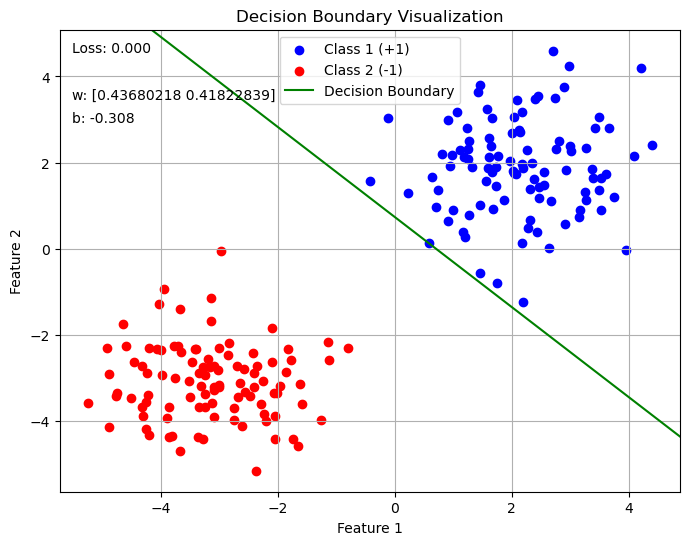

In [7]:
import matplotlib.animation as animation

def animate_decision_boundary(data, history, name):
    fig, ax = plt.subplots(figsize=(8, 6))

    class_1 = data[data[:, -1] == 1]
    class_2 = data[data[:, -1] == -1]
    ax.scatter(class_1[:, 0], class_1[:, 1], color='blue', label='Class 1 (+1)')
    ax.scatter(class_2[:, 0], class_2[:, 1], color='red', label='Class 2 (-1)')
    
    line, = ax.plot([], [], color='green', label='Decision Boundary')
    loss_text = ax.text(0.02, 0.95, '', transform=ax.transAxes) # Loss text
    w_text = ax.text(0.02, 0.85, '', transform=ax.transAxes)
    b_text = ax.text(0.02, 0.80, '', transform=ax.transAxes)


    x_min, x_max = ax.get_xlim()
    x = np.linspace(x_min, x_max, 100)

    def update(frame):
        w, b, loss = history[frame]
        if w[1] != 0:
            y = -(w[0] / w[1]) * x - (b / w[1])
            line.set_data(x, y)
        else:
            line.set_data([-b / w[0]]*100, x)  
        loss_text.set_text(f"Loss: {loss:.3f}")
        w_text.set_text(f"w: {w}")  # Display w
        b_text.set_text(f"b: {b:.3f}")  # Display b
        return line, loss_text, w_text, b_text  # Return all updated artists


    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend()
    ax.set_title('Decision Boundary Visualization')
    ax.grid()
    

    ani = animation.FuncAnimation(fig, update, frames=len(history), blit=True, interval=100, repeat=False)
    #plt.show()
    ani.save(name, writer='pillow') # Save as GIF




# Example usage
data = generate_data()
w, b, history = stochastic_subgradient(data, learning_rate=0.15, num_of_epochs=10)
animate_decision_boundary(data, history, "decision_boundary2.gif")

What problem do we see? We have no control over which hyperplane it converges to. Looking at the gif, we see that once the hyperplane classifies all the points correctly, the subgradient is zero and no progress is made, but the distance to the closest point in class +1 is 0 and to the closest point in class -1 is much greater. Although it's obvious, the best choice is the hyperplane in the middle of the distance between 2 closest points of these classes. 
With this thoughts we come to SVM

## SVM

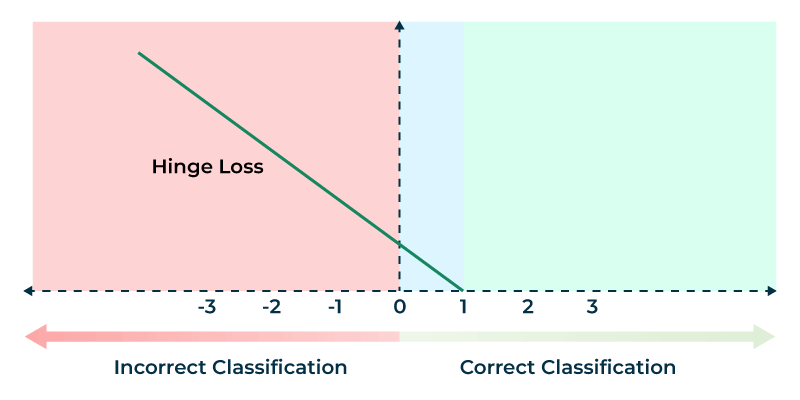

In [8]:
def hinge_loss(data, w, b, lmbd):
    X = data[:, :-1]
    y = data[:, -1]
    loss = np.maximum(0, 1 - y * (np.dot(X, w) + b)).mean() + 0.5*lmbd*(np.linalg.norm(w))**2
    return loss


In [9]:
def svm(data, learning_rate = 0.01, lmbd = 1, batch_size = 10, num_of_epochs=50):
    # data = generate_data()
    X = data[:, :-1]
    y = data[:, -1]
    num_samples, num_features = X.shape

    w = np.random.randn(num_features) *0.6
    b = np.random.randn() * 0.6
    
    history = [] # For animation frames

    for epoch in range(num_of_epochs):
        np.random.shuffle(data)
        for i in range(0, len(data), batch_size):
            batch = data[i:i+batch_size]
            grad_w = np.zeros_like(w)
            grad_b = 0.0
            for sample in batch:
                x_i = sample[:-1]
                y_i = sample[-1]
                if y_i * (np.dot(w, x_i) + b) < 1:   # now the distance must be at least 1
                    grad_w += (-y_i * x_i)
                    grad_b += (-y_i)
                grad_w += lmbd * w
            grad_w /= batch_size
            grad_b /= batch_size


            w -= learning_rate*grad_w
            b -= learning_rate*grad_b
            #print(f"w = {w}, b = {b}")
            loss = hinge_loss(data, w, b,lmbd)  # Calculate loss after update
            history.append((w.copy(), b, loss)) # Append for animation
    return w, b, history

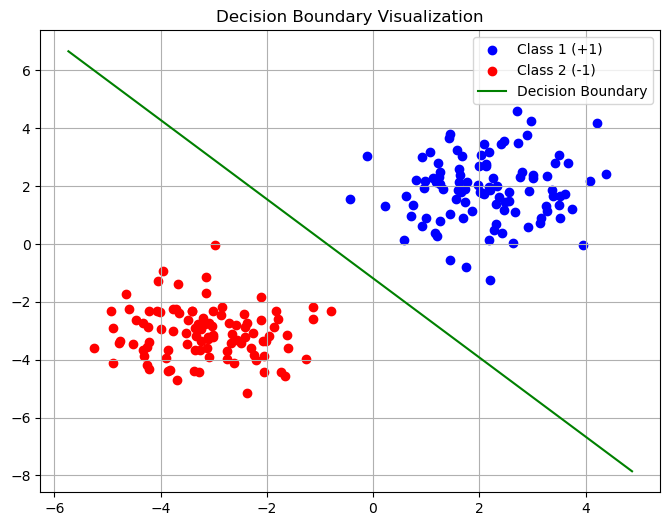

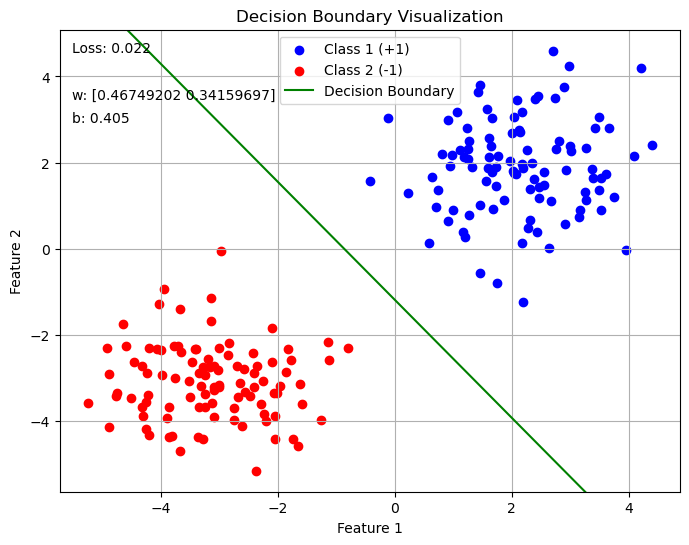

In [10]:
data = generate_data()
w, b, history = svm(data, batch_size=100, learning_rate=0.1, lmbd=0.1, num_of_epochs=80)
visualize_decision_boundary(data, w, b)
animate_decision_boundary(data, history, "SVM2.gif")